<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=179561859" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

## Imports

Below, i import all the libraries and datasets needed for this competition.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
!pip install openfe

In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform



In [4]:
!ls /kaggle/input/playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [5]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [7]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [8]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
#original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [9]:
#train_df.shape,original_df.shape

In [10]:
#train_df = pd.concat([train_df,original_df], axis=0)
#train_df.shape

In [11]:
#subset

train_subset = train_df.sample(n=200000,replace=False)
test_subset = test_df.sample(n=150000,replace=False)

In [12]:
train_subset.shape

(200000, 21)

# Baseline

This is a simple models with just the datasets provided excluding the original datasets and no extra feature engineering or feature transformatione except the defaults.

I will use random forests and neural networks as a baseline, usually i would use just the random forest since a neural network is more sensitive to parameter changes but for this case it seems to run faster, so i use i create 2 baselines.

Below i use the fastai cont_cat_split function to divide my columsn into categorical and continous variables.

In [23]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')

In [ ]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

In [24]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))

In [25]:
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [26]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [27]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

### Random Forest Baseline

In [28]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

CPU times: user 50.4 s, sys: 76.3 ms, total: 50.4 s
Wall time: 50.5 s


0.6120240869172946

### Neural Network

SuggestedLRs(slide=0.013182567432522774, valley=0.0012022644514217973)

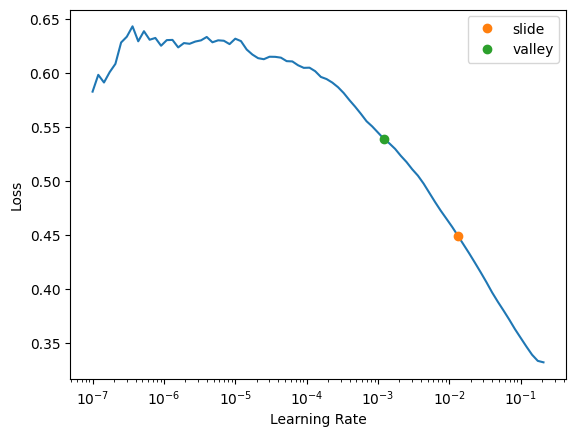

In [29]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [30]:
%%time
learn.fit_one_cycle(12,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.001085,0.001349,0.477405,00:37
1,0.000605,0.000452,0.824875,00:37
2,0.000664,0.000518,0.799408,00:37
3,0.000616,0.000475,0.816128,00:37
4,0.000593,0.000463,0.820623,00:36
5,0.000583,0.001180,0.542687,00:35
6,0.000569,0.150154,-57.185172,00:35
7,0.000527,0.006659,-1.580511,00:34
8,0.000494,0.001746,0.323591,00:35
9,0.000465,0.000414,0.839719,00:35


CPU times: user 7min 11s, sys: 2.81 s, total: 7min 14s
Wall time: 7min 15s


In [31]:
dl = learn.dls.test_dl(test_subset)

In [32]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 26.8 s, sys: 141 ms, total: 26.9 s
Wall time: 26.8 s


In [33]:
#dataset no original training subset with new openFE features
r2_score(y_test,nn_preds_x)

0.8525719134742764

So our random forest returns an r2score of **0.6120240869172946** while our neural network returns a score of **0.8525719134742764**.

So from now on, our goal will be to try to improve this score.

# Adding Original Dataset

In [34]:
original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [35]:
original_df.shape

(50000, 21)

In [38]:
train_final = pd.concat([train_df,original_df], axis=0)

In [39]:
train_final.shape

(1167957, 21)

In [40]:
#### Random Forest Baseline

In [43]:
cont_names,cat_names = cont_cat_split(train_final, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_final))
to = TabularPandas(train_final, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [44]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

CPU times: user 6min, sys: 763 ms, total: 6min 1s
Wall time: 6min 1s


0.6504381557189793

SuggestedLRs(slide=0.005248074419796467, valley=0.0004786300996784121)

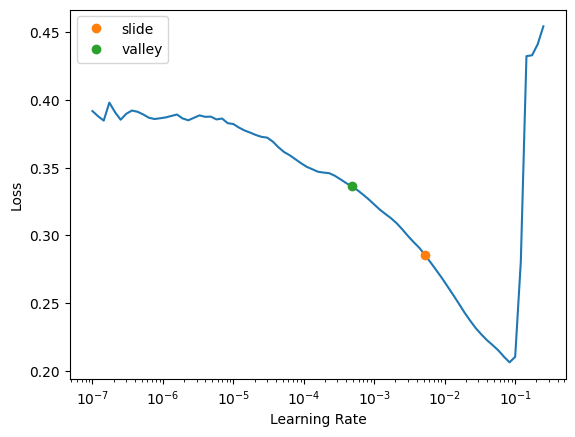

In [47]:
learn1 = tabular_learner(dls, metrics=R2Score())
learn1.lr_find(suggest_funcs=(slide,valley))

In [48]:
%%time
learn1.fit_one_cycle(12,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000786,0.000778,0.700291,03:34
1,0.000537,0.000422,0.837273,03:48
2,0.000606,0.000437,0.831830,03:45
3,0.000575,0.000423,0.837155,03:37
4,0.000571,0.000502,0.806579,03:37
5,0.000555,0.001011,0.610671,03:46
6,0.000493,0.000538,0.792843,03:43
7,0.000480,0.000444,0.829046,03:36
8,0.000495,0.000438,0.831190,03:37
9,0.000454,0.000382,0.852975,03:35


CPU times: user 43min 28s, sys: 17.9 s, total: 43min 46s
Wall time: 43min 53s


In [57]:
dl = learn1.dls.test_dl(test_subset)

In [58]:
%%time
nn_preds = learn1.get_preds(dl=dl)
nn_preds_x = learn1.get_preds()[0]
a_preds, _ = learn1.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 50.2 s, sys: 209 ms, total: 50.4 s
Wall time: 50.2 s


In [59]:
nn_preds_x.shape

torch.Size([233591, 1])

In [60]:
#dataset with original training subset with new openFE features
r2_score(y_test,nn_preds_x)

0.8578640002891056

Random forest now scores **0.6504381557189793** while the neural network scores **0.8578640002891056** which is an improvement from our previous scores.

We can conclude that adding the original dataset improves the model's results.

# Introducing Open FE 

So i

### Excluding original dataset

In [13]:
ofe = OpenFE()

In [14]:
#set n_jobs to be the actual cpu core count
CPU_COUNT = os.cpu_count()
n_jobs = CPU_COUNT
n_jobs

4

In [15]:
y_names='FloodProbability'

In [86]:
#features = ofe.fit(data=train_subset.drop('FloodProbability',axis=1), label=train_subset['FloodProbability'], n_jobs=n_jobs)  # generate new features
#train_x, test_x = transform(train_z, test_subset, features, n_jobs=n_jobs) # transform the train and test data according to generated features.

Concating the original dataframe before running the OpenFE feature generation tool seems to result in a NameError.
This needs further investigation.

In [16]:
params = {"n_estimators": 1000, "importance_type": "gain", "num_leaves": 64,"seed": 1, "n_jobs": n_jobs}

In [ ]:
%%time
from openfe import OpenFE, get_candidate_features, transform, tree_to_formula

ofe1 = OpenFE()
candidate_features_list = get_candidate_features(numerical_features=list(test_subset.columns))
features1 = ofe1.fit(data=train_subset.drop(y_names,axis=1), label=train_subset[y_names],
                     candidate_features_list=candidate_features_list, metric='rmse', task='regression', stage2_params=params,
                     min_candidate_features=5000,
                     n_jobs=n_jobs, n_data_blocks=2, feature_boosting=True)
  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 20
[LightGBM] [Info] Start training from score 0.504612
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1275]	valid_0's rmse: 0.0208361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 20
[LightGBM] [Info] Start training from score 0.504500
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1844]	valid_0's rmse: 0.0208636
[LightGBM] [Info] Auto-choosing col-wise multi-threading

  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bin

  6%|▋         | 1/16 [00:22<05:37, 22.53s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No 

 12%|█▎        | 2/16 [00:25<02:33, 10.95s/it]

[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-th

 19%|█▉        | 3/16 [00:26<01:22,  6.37s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 25%|██▌       | 4/16 [00:31<01:09,  5.79s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set

 31%|███▏      | 5/16 [00:47<01:46,  9.71s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further split

 38%|███▊      | 6/16 [00:50<01:12,  7.22s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bins 18

[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 80000, numb

 44%|████▍     | 7/16 [00:51<00:47,  5.25s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

 50%|█████     | 8/16 [00:55<00:39,  4.99s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bins 68

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bi

 56%|█████▋    | 9/16 [01:04<00:42,  6.06s/it]

[LightGBM] [Info] Total Bins 25[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best ga

  6%|▋         | 1/16 [00:32<08:02, 32.17s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004904 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003330 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bin

 12%|█▎        | 2/16 [00:32<03:07, 13.40s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Total Bins 117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_co

 19%|█▉        | 3/16 [00:36<01:56,  9.00s/it]

[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006952 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further sp

 25%|██▌       | 4/16 [00:36<01:06,  5.57s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 26[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 50%|█████     | 8/16 [01:10<00:48,  6.06s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further split

In [34]:
train_new, test_new = transform(train_subset.drop(y_names,axis=1), test_subset, features1[:300], n_jobs=n_jobs)  

In [27]:
# Merge train_new with train_df to add the 'FloodProbability' column
merged_train_new = pd.merge(train_new, train_subset[['FloodProbability']], left_index=True, right_index=True)
merged_train_new

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,autoFE_f_291,autoFE_f_292,autoFE_f_293,autoFE_f_294,autoFE_f_295,autoFE_f_296,autoFE_f_297,autoFE_f_298,autoFE_f_299,FloodProbability
openfe_index,,,,,,,,,,,,,,,,,,,,,
25031,4,12,3,7,5,5,5,5,5,1,...,20.0,1.000000,4.0,20.0,0.0,7.0,-2.0,5.0,4.0,0.495
324828,8,2,8,10,2,5,3,6,7,4,...,18.0,0.375000,3.0,9.0,3.0,2.0,3.0,8.0,3.0,0.535
698052,2,1,4,3,4,7,6,5,8,10,...,35.0,1.750000,4.0,24.0,-2.0,1.0,-3.0,7.0,4.0,0.530
661165,4,8,2,4,4,2,9,5,11,6,...,10.0,1.285714,2.0,27.0,-4.0,2.0,0.0,2.0,2.0,0.435
922824,8,5,3,8,6,8,1,6,12,10,...,18.0,5.500000,2.0,6.0,-5.0,5.0,-5.0,8.0,5.0,0.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199446,5,8,3,4,4,5,6,5,3,7,...,20.0,0.666667,4.0,24.0,1.0,5.0,-2.0,5.0,4.0,0.460
824195,6,2,6,5,7,6,5,7,4,5,...,35.0,1.666667,3.0,25.0,2.0,2.0,0.0,6.0,3.0,0.530
737977,4,4,4,3,4,6,6,8,4,3,...,64.0,1.000000,6.0,30.0,2.0,4.0,-2.0,6.0,5.0,0.485


In [29]:
cont_names,cat_names = cont_cat_split(merged_train_new, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(merged_train_new))
to = TabularPandas(merged_train_new, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_subset)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing

SuggestedLRs(slide=0.015848932787775993, valley=0.0008317637839354575)

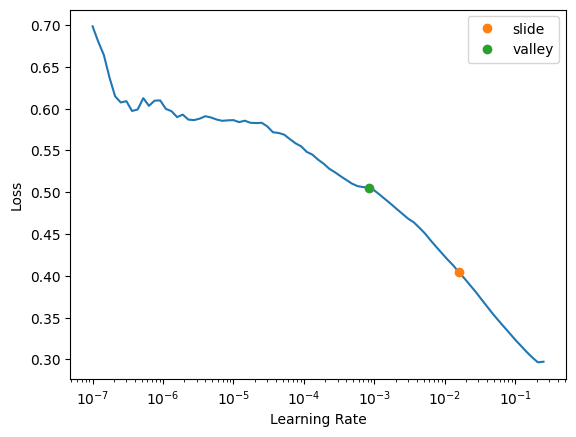

In [30]:
learn1 = tabular_learner(dls, metrics=R2Score())
learn1.lr_find(suggest_funcs=(slide,valley))

In [31]:
%%time
learn1.fit_one_cycle(12,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000916,0.000868,0.669280,00:58
1,0.000552,0.000416,0.841683,01:00
2,0.000581,0.000484,0.815589,00:58
3,0.000585,0.000705,0.731460,00:59
4,0.000531,0.000405,0.845771,00:57
5,0.000521,0.000429,0.836653,00:57
6,0.000508,0.000397,0.848591,00:57
7,0.000464,0.000398,0.848526,00:57
8,0.000495,0.000382,0.854620,00:57
9,0.000461,0.000386,0.853070,00:57


CPU times: user 11min 32s, sys: 3.04 s, total: 11min 35s
Wall time: 11min 35s


In [32]:
train_df.shape,train_new.shape

((1117957, 21), (200000, 320))

In [35]:
dl = learn1.dls.test_dl(test_new)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [36]:
%%time
nn_preds = learn1.get_preds(dl=dl)
nn_preds_x = learn1.get_preds()[0]
a_preds, _ = learn1.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 1min 35s, sys: 1.42 s, total: 1min 36s
Wall time: 1min 35s


In [37]:
#dataset without original dataset,and using training subset with new openFE features
r2_score(y_test,nn_preds_x)

0.8555863540227375

I believe the features add a slight improvement, next would be to add the original dataset and reduce the features

its better Uconcat probablyly throws an erro, so 

In [ ]:
#train_final = pd.concat([train_x, train_new], axis=1) 
#test_final = pd.concat([test_x, test_new], axis=1)

## Dataset Subset

Since the dataset is large and takes a while to train, we can use a subset of the data for quick experimentation

### Using random subset

Using a random subset results in better and faster training

In [ ]:
#train_subset = train_df.sample(n=50000,replace=False)
#test_subset = test_df.sample(n=30000,replace=False)

## Using Full Dataset

In [ ]:
train_df.shape,train_final.shape

In [ ]:
if 'FloodProbability' in train_new.columns:
    print("Column exists")
else:
    print("Column does not exist")


In [ ]:
train_df = train_new
train_df.shape

In [ ]:
# Merge train_new with train_df to add the 'FloodProbability' column
merged_train_new = pd.merge(train_new, train_df[['FloodProbability']], left_index=True, right_index=True)
merged_train_new

In [57]:
# Merge train_new with train_df to add the 'FloodProbability' column
merged_train_new = pd.merge(train_new, train_subset[['FloodProbability']], left_index=True, right_index=True)
merged_train_new

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,autoFE_f_291,autoFE_f_292,autoFE_f_293,autoFE_f_294,autoFE_f_295,autoFE_f_296,autoFE_f_297,autoFE_f_298,autoFE_f_299,FloodProbability
openfe_index,,,,,,,,,,,,,,,,,,,,,
503258,7,5,7,8,3,6,5,4,4,5,...,0.0,9.0,12.0,7.0,9.0,5.0,1.0,13.0,5.0,0.505
888180,5,5,8,5,5,5,7,5,3,11,...,-1.0,10.0,10.0,14.0,14.0,7.0,1.0,10.0,11.0,0.590
1096427,7,3,5,2,4,4,3,7,7,4,...,5.0,10.0,12.0,9.0,11.0,10.0,3.0,5.0,7.0,0.515
357587,7,4,2,11,2,6,8,6,9,5,...,4.0,17.0,12.0,14.0,14.0,8.0,2.0,15.0,6.0,0.540
239801,4,7,7,10,4,6,7,8,4,1,...,3.0,11.0,8.0,9.0,5.0,5.0,0.0,17.0,8.0,0.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327058,5,4,1,8,3,4,4,4,6,4,...,2.0,10.0,6.0,8.0,10.0,7.0,2.0,12.0,4.0,0.410
819692,2,4,3,4,7,7,7,5,5,6,...,-1.0,12.0,49.0,14.0,11.0,6.0,1.0,8.0,6.0,0.535
1111768,4,9,7,1,4,2,6,2,4,6,...,-1.0,10.0,16.0,9.0,10.0,3.0,2.0,10.0,6.0,0.440


In [58]:
cont_names,cat_names = cont_cat_split(merged_train_new, dep_var='FloodProbability')

In [59]:
splits = RandomSplitter(valid_pct=0.2)(range_of(merged_train_new))

In [60]:
to = TabularPandas(merged_train_new, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing

In [61]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [62]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_new)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [ ]:
# Assuming 'df' is your DataFrame
merged_train_new.to_csv('merged_train_new.csv', index=False, encoding='utf-8')


In [ ]:
!ls

In [ ]:
merged_train_new.to_pickle('merged_train_new.pkl')

In [ ]:
!ls

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('merged_train_new.csv')
FileLink('merged_train_new.pkl')

# Random Forest Baseline

We initially use a random forest as a baseline since it is a really simple model that doesnt break easily with small changes in the hyperparameters etc. 

We can also easily use this for explanability with features such as feature importance.

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

# Neural Network Baseline

SuggestedLRs(slide=0.013182567432522774, valley=0.0006918309954926372)

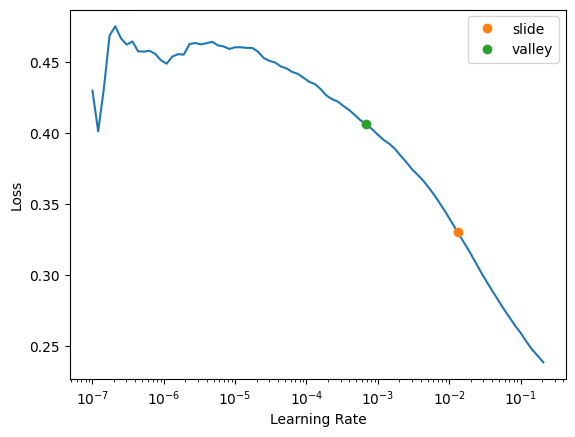

In [63]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
#%%time
#learn.fit_one_cycle(12,lr_max=slice(learn.valley))


In [64]:
%%time
learn.fit_one_cycle(12,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000801,0.000551,0.790989,00:59
1,0.000516,0.000424,0.839318,00:59
2,0.000527,0.000408,0.845371,00:59
3,0.000550,0.000400,0.848317,00:59
4,0.000527,0.000433,0.835932,00:59
5,0.000542,0.000515,0.804943,00:59
6,0.000499,0.000429,0.837430,00:59
7,0.000481,0.000383,0.854681,01:00
8,0.000478,0.000392,0.851478,01:00
9,0.000464,0.000381,0.855584,01:01


CPU times: user 11min 56s, sys: 2.9 s, total: 11min 59s
Wall time: 12min


In [65]:
dl = learn.dls.test_dl(test_new)


/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [66]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 1min 39s, sys: 1.47 s, total: 1min 41s
Wall time: 1min 40s


In [ ]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [38]:
#dataset no original training subset with new openFE features
r2_score(y_test,nn_preds_x)

0.8555863540227375

In [4]:
#dataset no original training subset with new openFE features
r2_score(y_test,nn_preds_x)

NameError: name 'y_test' is not defined

# Neural Network Ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(6, 0.02)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
nn_preds_x.shape,ens_preds.shape

In [ ]:
r2_score(y_test,nn_preds_x)

In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['FloodProbability'] = target_preds

In [ ]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
!ls

# Optimize Params with Optuna

CatBoost - Optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score


study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=200)
print(study_catboost.best_params)

LightGBM - Optuna

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print(study_lgbm.best_params)

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    model = lgb.LGBMRegressor(**params,verbose=False)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

In [ ]:
# Function Optuna
def objective(trial):
    # Define parameters to be optimized
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    # Train the model
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
    model.fit(X_train, y_train)
    
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score
    
   

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters and best R^2 score
best_params = study.best_params
best_r2 = study.best_value

print("Best R^2 score:", best_r2)
print("Best parameters:", best_params)

XGBoost - Optuna

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)
print(study_xgboost.best_params)

# CatBoost Baseline

In [68]:
#with optuna params
cat_model = CatBoostRegressor(iterations=2000, depth=9, learning_rate= 0.29776650862748444, random_strength=3)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8414981959259584

In [ ]:
print(study_catboost.best_params)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=50=00, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

# Light GBM

optuna params

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print(study_lgbm.best_params)

In [ ]:
print(study_lgbm.best_params)

In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)



In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150)
print(study_lgbm.best_params)



In [ ]:
{'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}
{'num_leaves': 25, 'learning_rate': 0.010094365133109197, 'n_estimators': 100}
{'num_leaves': 20, 'learning_rate': 0.010218030489864638, 'n_estimators': 100} - 150 trials

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=26, learning_rate=0.01001653579832905, n_estimators=110)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

In [ ]:
#100 trials
lgb_model = lgb.LGBMRegressor(num_leaves=25, learning_rate=0.010094365133109197, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

In [ ]:
#150 trials
lgb_model = lgb.LGBMRegressor(num_leaves=20, learning_rate=0.010218030489864638, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1,min_child_samples=171, subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1, boosting_type='gbdt',min_child_samples=171, random_state=27,subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

Initial baseline

In [69]:
lgb_model = lgb.LGBMRegressor(num_leaves=500, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27,subsample_for_bin=20698, reg_alpha=1.12032585776774e-09, reg_lambda=3.2869705488456358, colsample_bytree =  0.5441783735468184, subsample= 0.9370755150709044)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.483800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14139
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 360
[LightGBM] [Info] Start training from score 0.504670


0.8407008170872311

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
sub

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

# General Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

In [ ]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
!ls

In [ ]:
general_preds.shape

In [70]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

tensor([0.4167, 0.4979, 0.5194,  ..., 0.4967, 0.4833, 0.4927])

# Scoring

In [71]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

ValueError: Length of values (150000) does not match length of index (745305)

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
